In [13]:
import os, sys

# 1) Set notebook working directory = FaceStats project root
PROJECT_ROOT = "/Users/jayklarin/__DI/Repositories/FaceStats"
os.chdir(PROJECT_ROOT)
print("cwd:", os.getcwd())

# 2) Add src/ folder to Python PATH
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

print("src path added:", SRC_PATH)


cwd: /Users/jayklarin/__DI/Repositories/FaceStats
src path added: /Users/jayklarin/__DI/Repositories/FaceStats/src


In [14]:
import polars as pl

# ============================================================
# Step 1 — Load Full Attribute Table
# ============================================================

ATTR_PATH = "data/processed/metadata/attractiveness_with_attributes.parquet"

print("Loading full dataset…")
df = pl.read_parquet(ATTR_PATH)

print("Loaded dataset:", df.shape)
print(df.head())


Loading full dataset…
Loaded dataset: (700, 6)
shape: (5, 6)
┌───────────────────────┬──────────────┬──────┬──────────────┬─────────────────┬────────────────┐
│ filename              ┆ embedding    ┆ age  ┆ gender_final ┆ ethnicity_final ┆ attractiveness │
│ ---                   ┆ ---          ┆ ---  ┆ ---          ┆ ---             ┆ ---            │
│ str                   ┆ list[f64]    ┆ null ┆ str          ┆ str             ┆ f32            │
╞═══════════════════════╪══════════════╪══════╪══════════════╪═════════════════╪════════════════╡
│ SFHQ_pt4_00001843.jpg ┆ [0.07163,    ┆ null ┆ unknown      ┆ unknown         ┆ 2.914631       │
│                       ┆ -0.028173, … ┆      ┆              ┆                 ┆                │
│                       ┆ -0.0075…     ┆      ┆              ┆                 ┆                │
│ SFHQ_pt4_00000591.jpg ┆ [0.027857,   ┆ null ┆ male         ┆ white           ┆ 2.938567       │
│                       ┆ -0.008046, … ┆      ┆          

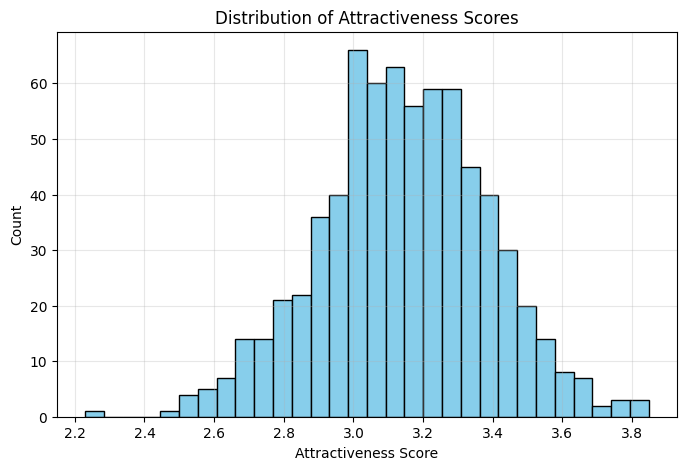

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------------
# Step 2 — Visualize Attractiveness Distribution
# -------------------------------------------------------------

scores = df["attractiveness"].fill_null(np.nan).to_numpy()

plt.figure(figsize=(8, 5))
plt.hist(scores, bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Attractiveness Score")
plt.ylabel("Count")
plt.title("Distribution of Attractiveness Scores")
plt.grid(alpha=0.3)
plt.show()


/var/folders/gz/0c41mw6j22x4rm3rkhgx2_3h0000gn/T/ipykernel_46127/3073873665.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


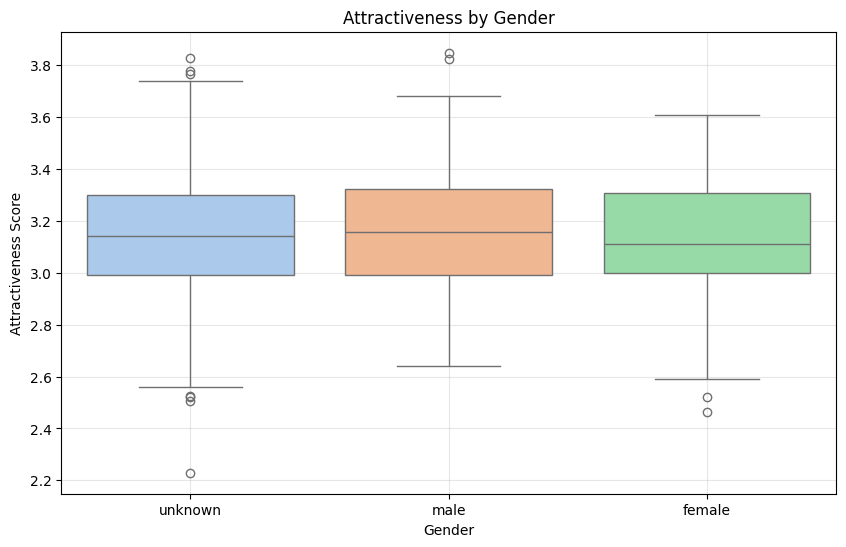

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to pandas for easy plotting
pdf = df.to_pandas()

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=pdf,
    x="gender_final",
    y="attractiveness",
    palette="pastel"
)

plt.title("Attractiveness by Gender")
plt.xlabel("Gender")
plt.ylabel("Attractiveness Score")
plt.grid(alpha=0.3)
plt.show()


/var/folders/gz/0c41mw6j22x4rm3rkhgx2_3h0000gn/T/ipykernel_46127/3655446801.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


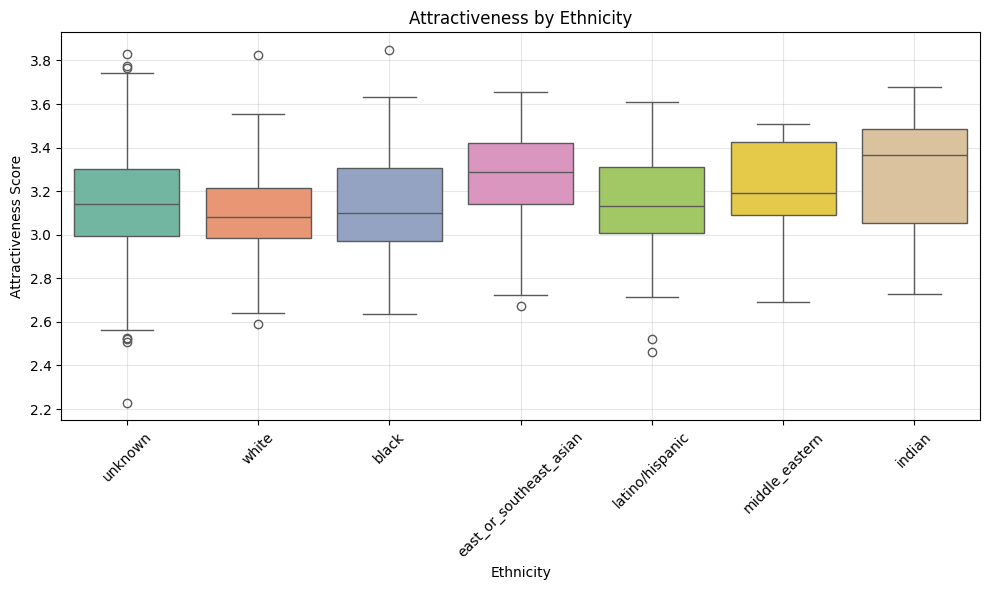

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df.to_pandas(),
    x="ethnicity_final",
    y="attractiveness",
    palette="Set2"
)

plt.xticks(rotation=45)
plt.xlabel("Ethnicity")
plt.ylabel("Attractiveness Score")
plt.title("Attractiveness by Ethnicity")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


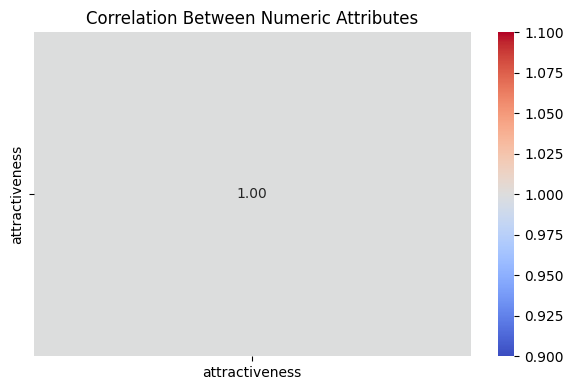

In [18]:
# ============================================================
# Step 4 — Correlation Matrix of Attributes
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Polars → Pandas for seaborn
df_pd = df.to_pandas()

# Select numeric columns only
numeric_cols = ["attractiveness"]

# Only include age if we later populate it
if "age" in df_pd.columns:
    if df_pd["age"].notna().any():
        numeric_cols.append("age")

# Build correlation matrix
corr = df_pd[numeric_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Numeric Attributes")
plt.tight_layout()
plt.show()


Preparing PCA...
Running PCA...


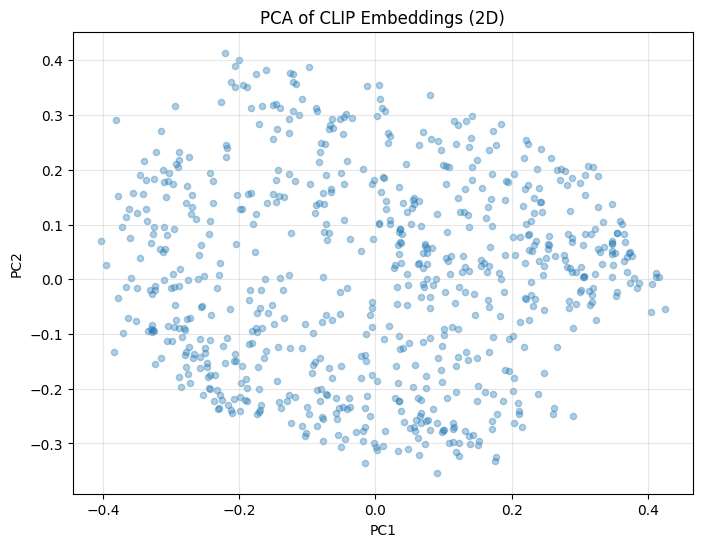

In [19]:
# ============================================================
# Step 5 — PCA Visualization of Embeddings (2D)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print("Preparing PCA...")

# Convert embeddings (list[f64]) into a numpy matrix
X = np.vstack(df_pd["embedding"].to_list())

print("Running PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Add PCA coords back to DataFrame for plotting
df_pd["pca_x"] = X_pca[:, 0]
df_pd["pca_y"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(df_pd["pca_x"], df_pd["pca_y"], s=20, alpha=0.35)
plt.title("PCA of CLIP Embeddings (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.show()


In [20]:
from sklearn.decomposition import PCA
import numpy as np
import polars as pl

print("Preparing PCA…")

# Extract 512-D vectors as a numpy matrix
X = np.vstack(df["embedding"].to_list())

print("Running PCA…")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Build df_pca (Polars)
df_pca = df.with_columns([
    pl.Series("PC1", X_pca[:, 0]),
    pl.Series("PC2", X_pca[:, 1]),
])

# Convert to pandas for seaborn/matplotlib
df_pca = df_pca.to_pandas()

df_pca.head()


Preparing PCA…
Running PCA…


,filename,embedding,age,gender_final,ethnicity_final,attractiveness,PC1,PC2
0,SFHQ_pt4_00001843.jpg,"[0.07163044810295105, -0.028172777965664864, -...",None,unknown,unknown,2.914631,0.305873,0.003549
1,SFHQ_pt4_00000591.jpg,"[0.027856823056936264, -0.00804600864648819, -...",None,male,white,2.938567,-0.001686,-0.298522
2,SFHQ_pt4_00002437.jpg,"[0.06561432778835297, -0.01843235269188881, -0...",None,unknown,unknown,3.175123,0.032623,0.062435
3,SFHQ_pt4_00002345.jpg,"[0.06453648209571838, -0.023444291204214096, -...",None,unknown,unknown,3.208316,-0.046439,0.107771
4,SFHQ_pt4_00003073.jpg,"[0.08010324090719223, -0.033260490745306015, -...",None,unknown,unknown,3.280991,-0.013822,-0.149855


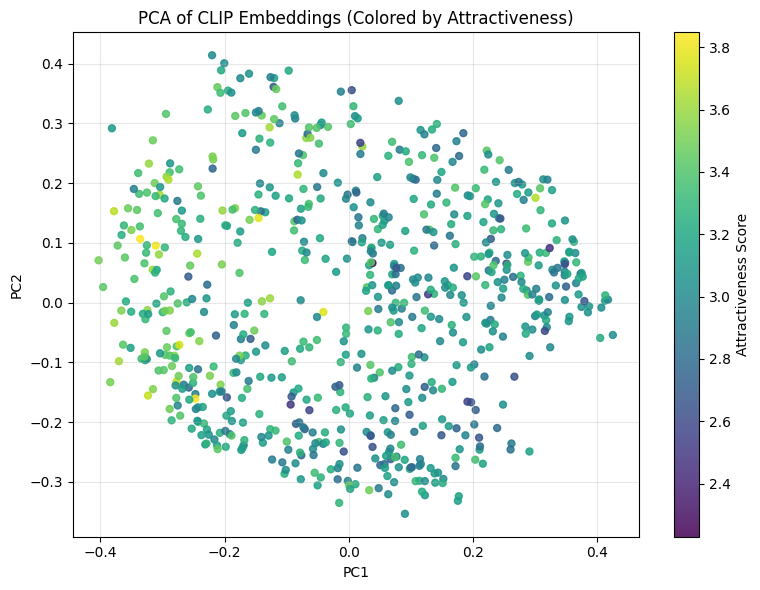

In [21]:
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# PCA colored by attractiveness
# ------------------------------------------------------------
x = df_pca["PC1"].to_numpy()
y = df_pca["PC2"].to_numpy()
attr = df_pca["attractiveness"].to_numpy()

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    x, y,
    c=attr,
    cmap="viridis",
    s=25,
    alpha=0.85
)

plt.colorbar(sc, label="Attractiveness Score")
plt.title("PCA of CLIP Embeddings (Colored by Attractiveness)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


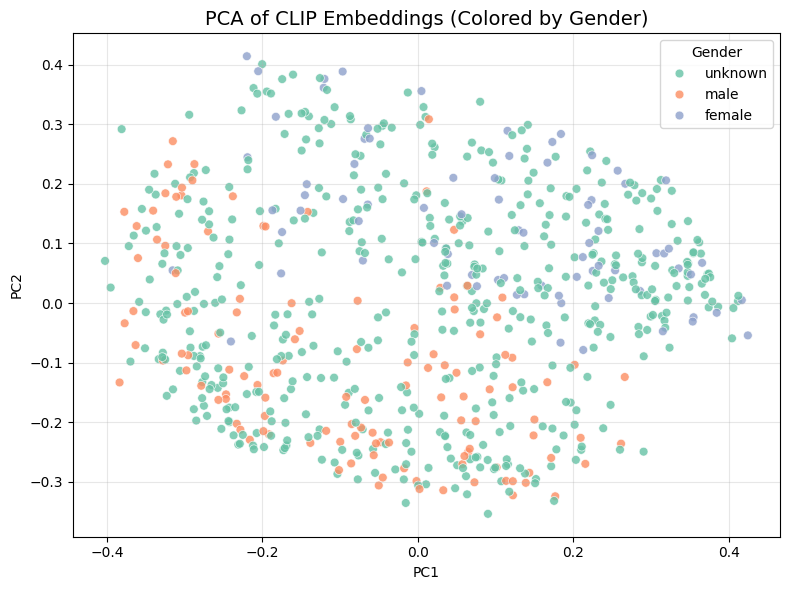

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out unknown genders for cleaner visualization (optional)
df_plot = df_pca.copy()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot,
    x="PC1",
    y="PC2",
    hue="gender_final",
    palette="Set2",
    s=40,
    alpha=0.8
)

plt.title("PCA of CLIP Embeddings (Colored by Gender)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


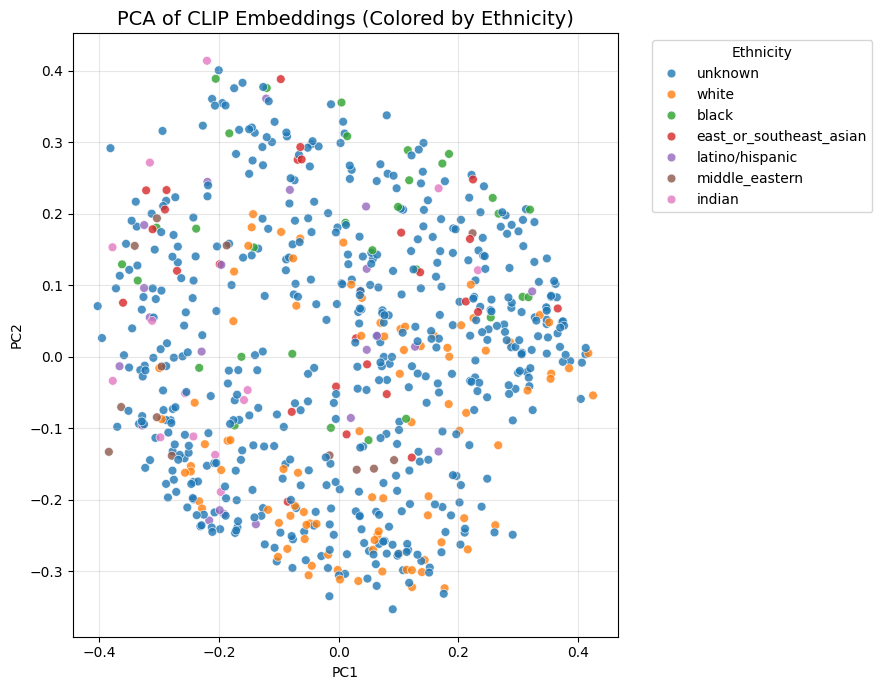

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = df_pca.copy()

plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=df_plot,
    x="PC1",
    y="PC2",
    hue="ethnicity_final",
    palette="tab10",
    s=40,
    alpha=0.8
)

plt.title("PCA of CLIP Embeddings (Colored by Ethnicity)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
